In [23]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
import pickle
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Import data and set variables

In [6]:
# Import data
train = pd.read_pickle('~/Documents/Github Repository/early-warning-twitter/Processed datasets/Model data/Train.pkl')

# Split up in X and y columns
X_train = train.loc[:, train.columns != 'has_Incident_Related']
y_train = train[['has_Incident_Related']]

# Variable with the text of a tweet without hashtags 
X_train_text_no_hashtag = X_train.loc[:, 'preprocessed_text_no_hashtag']

# Variable with the text of a tweet with hashtags as normal text
X_train_text = X_train.loc[:, 'preprocessed_text']

# Response variable, whether the tweet is related to an incident (0 or 1)
y_train = y_train.loc[:, 'has_Incident_Related'].astype('int')

# Convert text data into tf-idf

In [7]:
# Convert X_train_text_no_hashtag into tf-idf vectorized matrix
vc_text_no_hashtag = TfidfVectorizer().fit(X_train_text_no_hashtag)
X_train_text_no_hashtag_df = pd.DataFrame(vc_text_no_hashtag.transform(X_train_text_no_hashtag).todense(), columns=vc_text_no_hashtag.get_feature_names())

# Convert X_train_text into tf-idf vectorized matrix
vc_text = TfidfVectorizer().fit(X_train_text)
X_train_text_df = pd.DataFrame(vc_text.transform(X_train_text).todense(), columns=vc_text.get_feature_names())

In [5]:
# Reset index for all variables
X_train_text_no_hashtag_df.reset_index(inplace=True, drop=True)
X_train_text_df.reset_index(inplace=True, drop=True)

In [ ]:
parameters = {
    'loss':['deviance', 'exponential'],
    'learning_rate':[0.05, 0.1, 0.25, 0.5, 1],
    'n_estimators': [50,100,200],
    'criterion':['friedman_mse', 'mse'],
    'max_depth':[3,6,9]
}

def get_best_parameters(parameters, train, test, file):
    clf = GridSearchCV(
        GradientBoostingClassifier(), parameters, cv=3, scoring='f1', n_jobs=8, verbose=True
    )
    clf.fit(train, test)
    print(clf.best_score_)
    print(clf.best_params_)
    file.write(f"Best Score is {clf.best_score_} and the best params are {clf.best_params_}")

file1 = open("GradientBoosted1.txt","a")
get_best_parameters(parameters, X_train_text_no_hashtag_df, y_train, file1)
file1.close()

Fitting 3 folds for each of 180 candidates, totalling 540 fits


In [ ]:
file2 = open("GradientBoosted2.txt","a")
get_best_parameters(parameters, X_train_text_df, y_train, file2)
file2.close()

In [17]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf_gb1 = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.5, loss='exponential', max_depth=6, n_estimators=200)
scores1 = cross_validate(clf_gb1, X_train_text_no_hashtag_df, y_train, cv=k_fold, scoring='f1', return_train_score=True, n_jobs=8, verbose=1)

file1 = open("GradientBoosted1.txt","a")
file1.write("Model trained on text of the tweet without hashtag")
file1.write(f"Train score: {scores1['train_score'].mean()}")
file1.write(f"Test score: {scores1['test_score'].mean()}")
file1.close()

print("Model trained on text of the tweet without hashtag")
print("Train score: ", scores1['train_score'].mean())
print("Test score: ", scores1['test_score'].mean())
print("-----------------------------")

clf_gb2 = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.5, loss='exponential', max_depth=9, n_estimators=200)
scores2 = cross_validate(clf_gb2, X_train_text_df, y_train, cv=k_fold, scoring='f1', return_train_score=True, n_jobs=8, verbose=1)

file2 = open("GradientBoosted2.txt","a")
file2.write("Model trained on text of the tweet with hashtag")
file2.write(f"Train score: {scores1['train_score'].mean()}")
file2.write(f"Test score: {scores1['test_score'].mean()}")
file2.close()

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed: 12.8min remaining:  8.5min


Model trained on text of the tweet without hashtag
Train score:  0.9973777256822813
Test score:  0.8779615140583287
-----------------------------


[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed: 25.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed: 19.8min remaining: 13.2min
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed: 37.9min finished


In [18]:
clf_gb1.fit(X_train_text_no_hashtag_df, y_train)
clf_gb2.fit(X_train_text_df, y_train)

GradientBoostingClassifier(learning_rate=0.5, loss='exponential', max_depth=9,
                           n_estimators=200)

In [22]:
# Save models
pickle.dump(clf_gb1, open('Models/gradient-boosted-1.sav', 'wb'))
pickle.dump(clf_gb2, open('Models/gradient-boosted-2.sav', 'wb'))

In [2]:
# Load models
clf_gb1 = pickle.load(open('Models/gradient-boosted-1.sav', 'rb'))
clf_gb2 = pickle.load(open('Models/gradient-boosted-2.sav', 'rb'))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [7]:
# Import the Test data
test = pd.read_pickle('~/Documents/Github Repository/early-warning-twitter/Processed datasets/Model data/Test.pkl')

X_test = test.loc[:, test.columns != 'has_Incident_Related']
y_test = test[['has_Incident_Related']]

# Variable with the text of a tweet without hashtags 
X_test_text_no_hashtag = X_test.loc[:, 'preprocessed_text_no_hashtag']

# Variable with the text of a tweet with hashtags as normal text
X_test_text = X_test.loc[:, 'preprocessed_text']

# Response variable, whether the tweet is related to an incident (0 or 1)
y_test = y_test.loc[:, 'has_Incident_Related'].astype('int')

In [8]:
# Convert X_test_text_no_hashtag into tf-idf vectorized matrix
X_test_text_no_hashtag_df = pd.DataFrame(vc_text_no_hashtag.transform(X_test_text_no_hashtag).todense(), columns=vc_text_no_hashtag.get_feature_names())

# Convert X_test_text into tf-idf vectorized matrix
X_test_text_df = pd.DataFrame(vc_text.transform(X_test_text).todense(), columns=vc_text.get_feature_names())

# Reset index for all variables
X_test_text_no_hashtag_df.reset_index(inplace=True, drop=True)
X_test_text_df.reset_index(inplace=True, drop=True)

In [9]:
def predict_data(model, test_data, test_y):
    # predict the new document from the testing dataset
    y_pred = model.predict(test_data)

    # Predict the probabilities for the testing dataset (necessary for AUC)
    y_pred_prob = model.predict_proba(test_data)

    # compute the performance measures
    score1 = metrics.accuracy_score(test_y, y_pred)
    print("accuracy:   %0.3f" % score1)

    print(metrics.classification_report(test_y, y_pred,
                                                target_names=['Negative', 'Positive'], digits=3))

    print("confusion matrix:")
    print(metrics.confusion_matrix(test_y, y_pred))

    print('------------------------------')

    # Only keep probabilities for the positive outcome only
    y_pred_prob = y_pred_prob[:, 1]

    gb_auc = roc_auc_score(test_y, y_pred_prob)
    print('Gradient Boosted Decision Trees: ROC AUC=%.3f' % (gb_auc))
    nb_fpr, nb_tpr, _ = roc_curve(test_y, y_pred_prob)
    plt.plot(nb_fpr, nb_tpr, marker='.', label='Gradient Boosted Decision Trees')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    print("-------------------------------------")

accuracy:   0.936
              precision    recall  f1-score   support

    Negative      0.957     0.956     0.956      1014
    Positive      0.883     0.885     0.884       382

    accuracy                          0.936      1396
   macro avg      0.920     0.920     0.920      1396
weighted avg      0.936     0.936     0.936      1396

confusion matrix:
[[969  45]
 [ 44 338]]
------------------------------
Gradient Boosted Decision Trees: ROC AUC=0.966


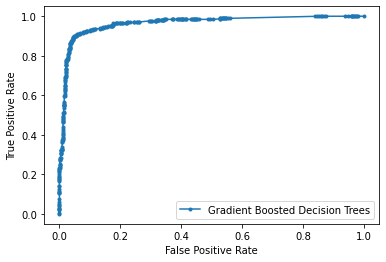

-------------------------------------
accuracy:   0.931
              precision    recall  f1-score   support

    Negative      0.949     0.956     0.952      1014
    Positive      0.880     0.864     0.872       382

    accuracy                          0.931      1396
   macro avg      0.915     0.910     0.912      1396
weighted avg      0.930     0.931     0.930      1396

confusion matrix:
[[969  45]
 [ 52 330]]
------------------------------
Gradient Boosted Decision Trees: ROC AUC=0.964


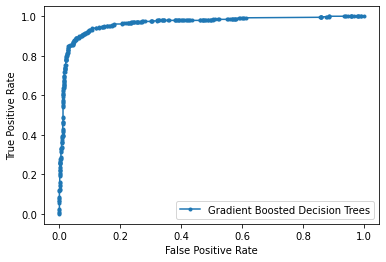

-------------------------------------


In [10]:
predict_data(clf_gb1, X_test_text_no_hashtag_df, y_test)
predict_data(clf_gb2, X_test_text_df, y_test)

# Get feature importance of words
Here, we get the feature importance of words for the best performing model in terms of the highest score of the F-measure on the test data

In [24]:
feature_importance = pd.DataFrame({"Feature":np.array(X_train_text_no_hashtag_df.columns), "Importance":clf_gb1.feature_importances_}).sort_values('Importance', ascending=False).head(10)
feature_importance

,Feature,Importance
8164,telegraaf,0.094815
1867,dam,0.050607
713,at5,0.045954
1956,demonstratie,0.041917
2344,duizenden,0.025430
410,afstand,0.012226
1509,burgemeester,0.009095
2997,gegooid,0.008810
8581,uitgedeeld,0.008296
229,aanwezig,0.008115
